# Desafio 4
### Eduardo Callejas P.


Sobre este ejemplo
  
1.
En esta sesión trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
- default : Variable Binaria. Registra si el cliente entró en morosidad o no.
- income: Ingreso promedio declarado por el cliente.
- balance: total del sando en la cuenta de crédito.
- student : Variable binaria. Registra si el cliente es estudiante o no.

## Desafío 1: Preparación de ambiente de trabajo
- Importe los módulos básicos para el análisis de datos.
- Importe las clases *LabelEncoder , StandardScaler y LabelBinarizer de preprocessing*
- Importe las funciones  y de model_selection 
- Importe la función classification_report de metrics
- Importe las clases *LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis* 
- Agregue la base de datos en el ambiente de trabajo.
- Inspeccione la distribución de cada atributo

In [1]:
#oversampler = SMOTE(random_state=11238, ratio='minority')
#X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import lec4_graphs as gfx
from graficos import classif_report





/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('default_credit.csv').drop(columns='index')

In [3]:
df.head()
target_label = df['default'].unique()



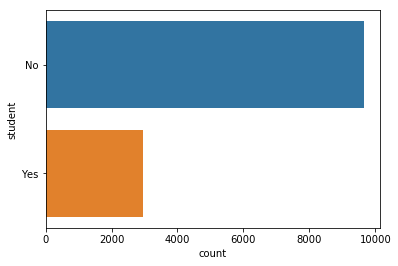

In [4]:
for column in ['default','student']:
    sns.countplot(y= df[column])

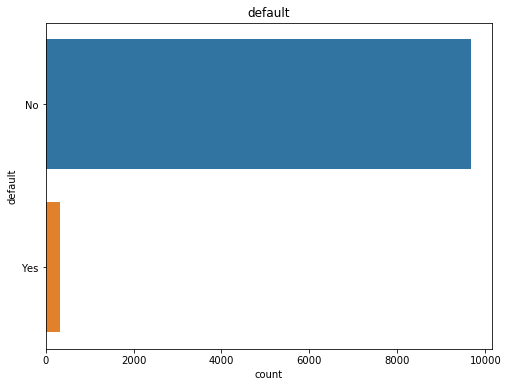

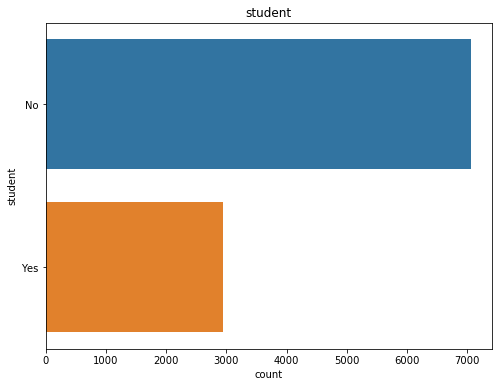

In [5]:
for i in {'student', 'default'}:
    plt.figure(figsize=(8, 6))
    plt.title(i)
    sns.countplot(y= df[i])

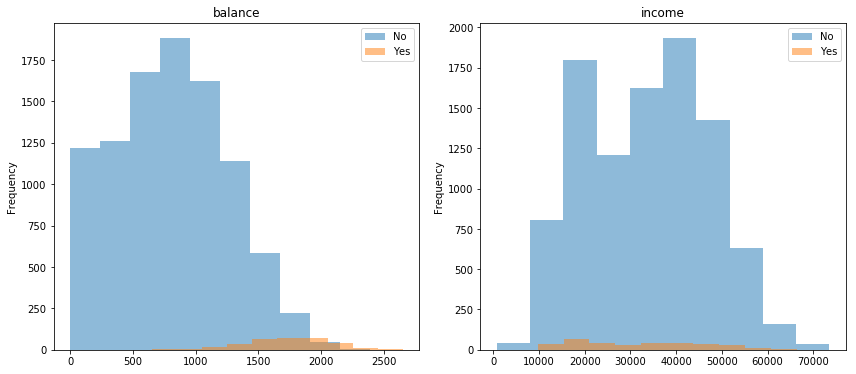

In [6]:
plt.figure(figsize=(12, 10))
for n, i in enumerate(df.drop(columns = ['default','student']).columns):
    plt.subplot(2, 2, n + 1)
    df.groupby('default')[i].plot(kind='hist', alpha=.5)
    plt.legend(df['default'].unique())
    plt.title(i)
    plt.tight_layout()

Hay muchos menos datos de personas sin default, lo que nos podria causar un desbalance de clases.
Por otro lado, en la clase balance se aprecia una diferencia entre aquellos que tienen default y no, sin embargo en income hay overlap entre ambas.

In [7]:
df['student'] = LabelEncoder().fit_transform(df['student'])
df['default'] = LabelEncoder().fit_transform(df['default'])



In [8]:
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [9]:
X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df.loc[:, 'student':'income'],
                                                                    df['default'],
                                                                    test_size=.33,
                                                                    random_state=3504)

In [11]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_mat, y_train_vec)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [12]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", 
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", 
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.96746269 0.03253731] 

Medias de atributos en cada clase
 [[2.900000e-01 8.049500e+02 3.371307e+04]
 [4.100000e-01 1.739020e+03 3.104687e+04]] 

Varianza explicada por cada discriminante
 [1.] 



In [13]:
lda_class_pred = lda_model.predict(X_test_mat)
lda_class_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

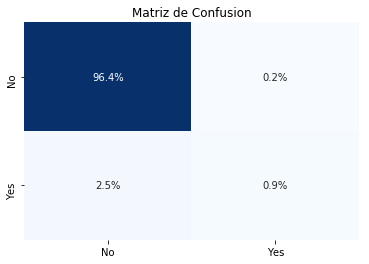

In [14]:
from sklearn.metrics import confusion_matrix


cnf = confusion_matrix(y_test_vec, lda_class_pred)/len(y_test_vec)
plt.title('Matriz de Confusion')
sns.heatmap(cnf, xticklabels=target_label,
            yticklabels=target_label,
            # generamos las anotaciones en términos porcentuales
            annot=True, fmt=".1%", 
            # evitamos la barra y cambiamos el colormap
            cbar=False, cmap='Blues')

In [15]:

pd.DataFrame(classification_report(y_test_vec, lda_class_pred,output_dict=True)).T



,f1-score,precision,recall,support
0,0.986199,0.974265,0.998430,3185.0
1,0.410596,0.861111,0.269565,115.0
micro avg,0.973030,0.973030,0.973030,3300.0
macro avg,0.698398,0.917688,0.633998,3300.0
weighted avg,0.966141,0.970321,0.973030,3300.0


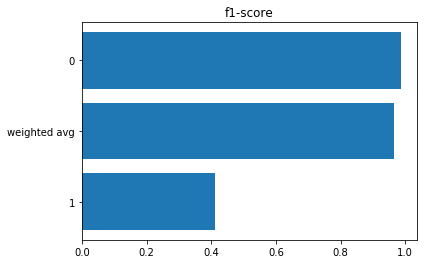

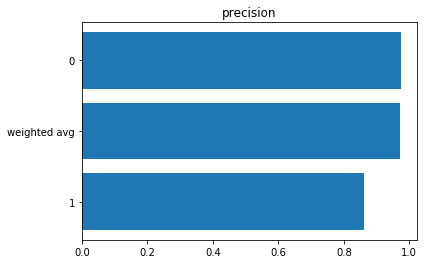

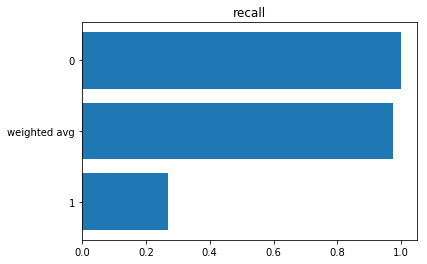

In [16]:
class_report = classification_report(y_test_vec, lda_class_pred,output_dict=True)
classif_report(class_report)

La clase sin deuda funciona bien, la clase con defaault tiene un recall muy bajo. Cabe notar que debido a que la clase de default =1 tiene muy pocos datos, el F1-score general sigue siendo alto

# Desafío 3: Refactorización 1 - información a priori
- Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
- Asumamos que hay un 50/50 de morosos y no morosos.
- Asumamos que hay un 60/40 de morosos y no morosos. Por cada modelo, reporte las métricas de clasificación.

In [17]:
lda_model = LinearDiscriminantAnalysis(priors=(0.5,0.5))
lda_model.fit(X_train_mat, y_train_vec)

LinearDiscriminantAnalysis(n_components=None, priors=(0.5, 0.5),
              shrinkage=None, solver='svd', store_covariance=False,
              tol=0.0001)

In [18]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", 
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", 
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.049500e+02 3.371307e+04]
 [4.100000e-01 1.739020e+03 3.104687e+04]] 

Varianza explicada por cada discriminante
 [1.] 



In [19]:
lda_class_pred = lda_model.predict(X_test_mat)
lda_class_pred[:20]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

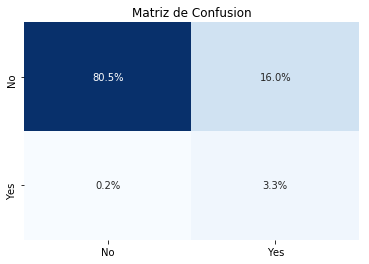

In [20]:

cnf = confusion_matrix(y_test_vec, lda_class_pred)/len(y_test_vec)
plt.title('Matriz de Confusion')
sns.heatmap(cnf, xticklabels=target_label,
            yticklabels=target_label,
            # generamos las anotaciones en términos porcentuales
            annot=True, fmt=".1%", 
            # evitamos la barra y cambiamos el colormap
            cbar=False, cmap='Blues')

In [21]:
pd.DataFrame(classification_report(y_test_vec, lda_class_pred,output_dict=True)).T

,f1-score,precision,recall,support
0,0.908500,0.997746,0.833909,3185.0
1,0.289509,0.170846,0.947826,115.0
micro avg,0.837879,0.837879,0.837879,3300.0
macro avg,0.599004,0.584296,0.890868,3300.0
weighted avg,0.886929,0.968930,0.837879,3300.0


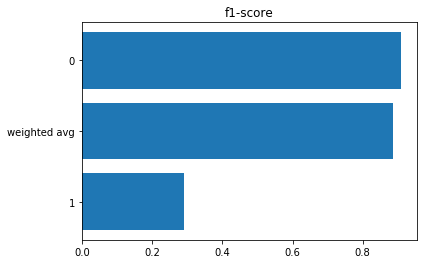

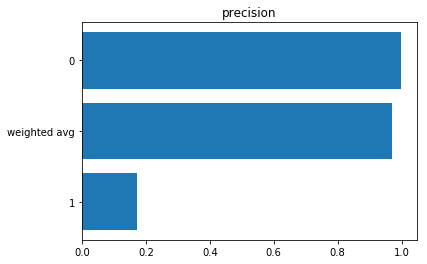

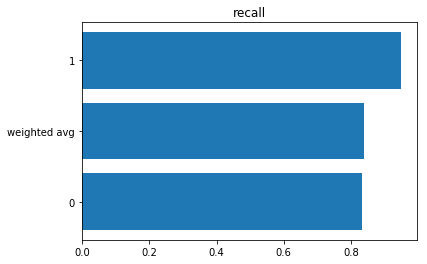

In [22]:
class_report = classification_report(y_test_vec, lda_class_pred,output_dict=True)
classif_report(class_report)

El F1 de los que si tienen deuda empeora :( 

In [23]:
lda_model = LinearDiscriminantAnalysis(priors=(0.4,0.6))
lda_model.fit(X_train_mat, y_train_vec)

LinearDiscriminantAnalysis(n_components=None, priors=(0.4, 0.6),
              shrinkage=None, solver='svd', store_covariance=False,
              tol=0.0001)

In [24]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", 
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", 
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.4 0.6] 

Medias de atributos en cada clase
 [[2.900000e-01 8.049500e+02 3.371307e+04]
 [4.100000e-01 1.739020e+03 3.104687e+04]] 

Varianza explicada por cada discriminante
 [1.] 



In [25]:
lda_class_pred = lda_model.predict(X_test_mat)
lda_class_pred[:20]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

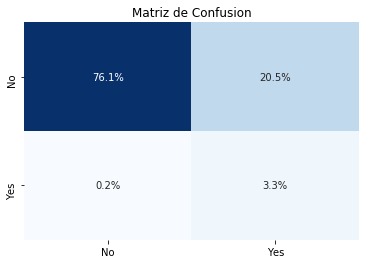

In [26]:

cnf = confusion_matrix(y_test_vec, lda_class_pred)/len(y_test_vec)
plt.title('Matriz de Confusion')
sns.heatmap(cnf, xticklabels=target_label,
            yticklabels=target_label,
            # generamos las anotaciones en términos porcentuales
            annot=True, fmt=".1%", 
            # evitamos la barra y cambiamos el colormap
            cbar=False, cmap='Blues')

In [27]:
pd.DataFrame(classification_report(y_test_vec, lda_class_pred,output_dict=True)).T

,f1-score,precision,recall,support
0,0.880547,0.997615,0.788069,3185.0
1,0.242492,0.139031,0.947826,115.0
micro avg,0.793636,0.793636,0.793636,3300.0
macro avg,0.561519,0.568323,0.867948,3300.0
weighted avg,0.858312,0.967695,0.793636,3300.0


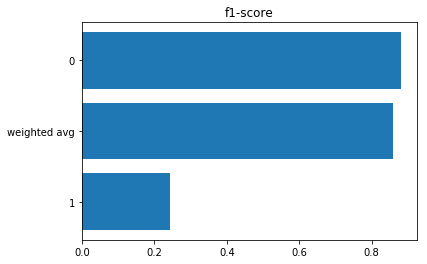

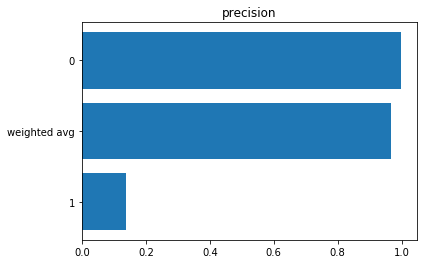

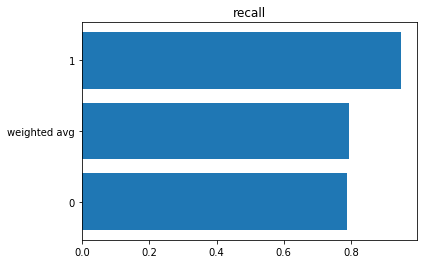

In [28]:
class_report = classification_report(y_test_vec, lda_class_pred,output_dict=True)
classif_report(class_report)

Empeora el f1 nuevamente :(

# Desafío 4: Refactorización 2 - oversampling
- Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos . Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis **from imblearn.over_sampling import SMOTE**
- Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:
- Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
oversampler = SMOTE(random_state=1234, ratio='minority')
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train_mat, y_train_vec)

In [31]:
X_train_oversamp

array([[0.00000000e+00, 6.16554650e+02, 4.61072079e+04],
       [0.00000000e+00, 1.78946451e+03, 2.74270046e+04],
       [0.00000000e+00, 2.67303728e+02, 2.31179287e+04],
       ...,
       [1.00000000e+00, 2.18168755e+03, 1.42948115e+04],
       [0.00000000e+00, 1.97169189e+03, 3.83293269e+04],
       [0.00000000e+00, 1.36505527e+03, 3.75803930e+04]])

In [32]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_oversamp, y_train_oversamp)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [33]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", 
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", 
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.049500e+02 3.371307e+04]
 [4.100000e-01 1.741250e+03 3.093063e+04]] 

Varianza explicada por cada discriminante
 [1.] 



In [34]:
lda_class_pred = lda_model.predict(X_test_mat)
lda_class_pred

array([0, 1, 0, ..., 0, 0, 0])

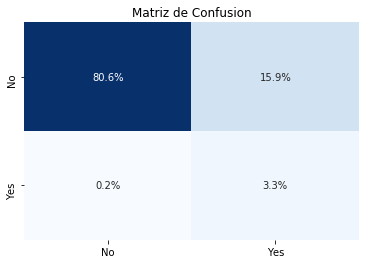

In [35]:

cnf = confusion_matrix(y_test_vec, lda_class_pred)/len(y_test_vec)
plt.title('Matriz de Confusion')
sns.heatmap(cnf, xticklabels=target_label,
            yticklabels=target_label,
            # generamos las anotaciones en términos porcentuales
            annot=True, fmt=".1%", 
            # evitamos la barra y cambiamos el colormap
            cbar=False, cmap='Blues')

In [36]:
pd.DataFrame(classification_report(y_test_vec, lda_class_pred,output_dict=True)).T

,f1-score,precision,recall,support
0,0.909091,0.997375,0.835165,3185.0
1,0.288770,0.170616,0.939130,115.0
micro avg,0.838788,0.838788,0.838788,3300.0
macro avg,0.598930,0.583996,0.887148,3300.0
weighted avg,0.887474,0.968564,0.838788,3300.0


Emepora nuevamente :( 

# Desafío 5: Refactorización 3 - QDA
- Por último, implemente un modelo *QuadraticDiscriminantAnalysis* con los datos aumentados artificialmente. Genere las métricas de desempeño.
- Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [1]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_oversamp, y_train_oversamp)

NameError: name 'QuadraticDiscriminantAnalysis' is not defined

In [38]:
print("Probabilidades a priori\n", qda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", 
      qda_model.means_.round(2), "\n")

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.049500e+02 3.371307e+04]
 [4.100000e-01 1.741250e+03 3.093063e+04]] 



In [39]:
qda_class_pred = qda_model.predict(X_test_mat)
qda_class_pred

array([0, 1, 0, ..., 0, 0, 0])

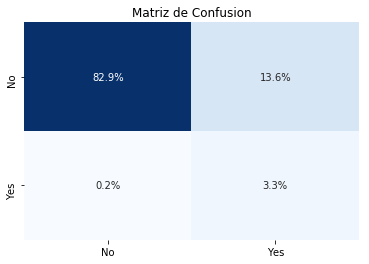

In [40]:

cnf = confusion_matrix(y_test_vec, qda_class_pred)/len(y_test_vec)
plt.title('Matriz de Confusion')
sns.heatmap(cnf, xticklabels=target_label,
            yticklabels=target_label,
            # generamos las anotaciones en términos porcentuales
            annot=True, fmt=".1%", 
            # evitamos la barra y cambiamos el colormap
            cbar=False, cmap='Blues')

In [41]:
class_report =classification_report(y_test_vec, qda_class_pred,output_dict=True)
pd.DataFrame(classification_report(y_test_vec, qda_class_pred,output_dict=True)).drop(columns=['micro avg','macro avg']).T

,f1-score,precision,recall,support
0,0.923259,0.997449,0.859341,3185.0
1,0.321908,0.194245,0.939130,115.0
weighted avg,0.902302,0.969459,0.862121,3300.0


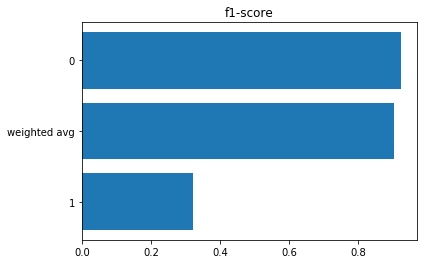

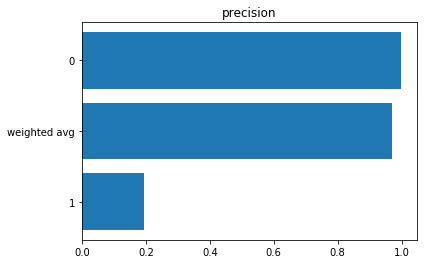

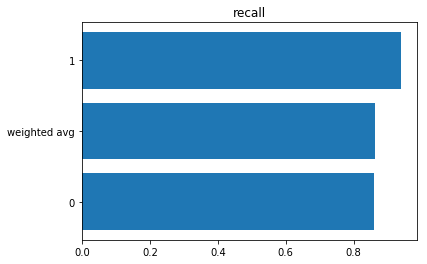

In [42]:
classif_report(class_report)

Mejora el modelo, sin embargo el precision de default='yes' sigue siendo bajo